In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

In [2]:
import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(denormalize(img).to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(img):
    return img.to('cpu') * torch.Tensor([0.229, 0.224, 0.225]).view((3,1,1)) + torch.tensor([[0.485, 0.456, 0.406]]).view((3,1,1))

def prepare_plots(attr, img):
    img = denormalize(img).numpy().transpose((1,2,0)) * 255
    attr = attr.to('cpu').numpy().transpose((1,2,0))
    return attr, img

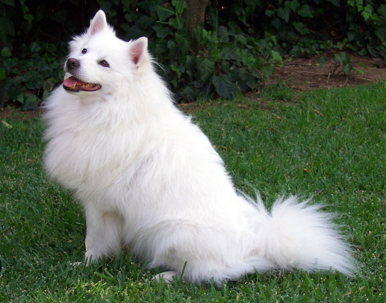

In [4]:
# Download an example image from the pytorch website
filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)
image.resize((v//4 for v in image.size))

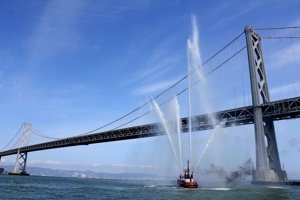

In [4]:
# sample execution (requires torchvision)
filename = "./data/fireboat.jpg"

from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)
image.resize((v//4 for v in image.size))

In [5]:
# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [8]:
from torch import nn

input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model
label = torch.LongTensor([categories.index("fireboat")])

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    label = label.to('cuda')
    model.to('cuda')

# inference
input_batch.requires_grad = True
output = model(input_batch)

# get gradient for input
criterion = nn.CrossEntropyLoss()
criterion(output, label).backward()

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

fireboat 0.9727038741111755
pier 0.0224001444876194
crane 0.0010487253312021494
steel arch bridge 0.0008774829329922795
suspension bridge 0.0007928009727038443


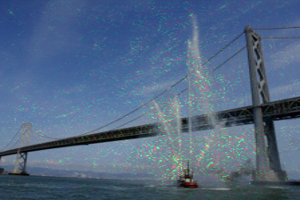

In [11]:
from VisualizationLibrary.visualization_lib import Visualize, show_pil_image, pil_image

pil_image(Visualize(
    *prepare_plots(input_batch.grad[0], input_image),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)).resize((v//4 for v in image.size))